# Trend Removal followed by catboost

Time series models tend to perform better when the dataset is 'stationary'.

A stationary series properties do not depend on the time value of a series. In statistics this means it has a constant mean, variance and no seasonality.  See <a href="https://otexts.com/fpp2/stationarity.html#fig:stationary">Forecasting: Principles and Practice</a> for examples of Stationary and non stationary datasets.
    
To get a constant mean, remove the trend.

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

#the following gives access to utils folder
#where utils package stores shared code
import os
import sys
PROJECT_ROOT = os.path.abspath(os.path.join(
                  os.getcwd(),
                  os.pardir)
)

#only add it once
if (PROJECT_ROOT not in sys.path):
    sys.path.append(PROJECT_ROOT)

import utils as ut
from IPython import get_ipython
ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

# Data
Use the tunnel dataset from <a href="https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data">Kaggle</a>.   It tracks the number of cars traveling through through the Baregg Tunnel in Switzerland each day from November 2003 to November 2005

In [85]:
#read data convert the Day dolumn to pandas datetime
df = pd.read_csv("../datasets/kaggle/tunnel.csv", parse_dates=["Day"])

#day is really date, change column name
df=df.rename(columns={"Day": "Date"})

df=df.set_index("Date")

#set a time index (just an integer from 0 to len dataframe)
df['Time']=np.arange(len(df))

## lets split out a test set.  <mark>You cannot use train_test_split with time series data. The earliest data is training data, the latest data is test data

In [86]:
def get_train_test(df,numb_test_rows=100):
    df_train=df.iloc[:-numb_test_rows,:].copy()
    print(df_train.shape)
    df_test=df.iloc[-numb_test_rows:,:].copy()
    print(df_test.shape)
    return df_train, df_test

df_train, df_test = get_train_test(df)

#save original predictions for rsquared calculations below
df_test_y_orig=df_test['NumVehicles']

(647, 2)
(100, 2)


## Plot the train and test set. Can you see a trend?
Can you see the trend below?  Is it linear?  Which direction does it go?  Is it exponential?  How would you know?

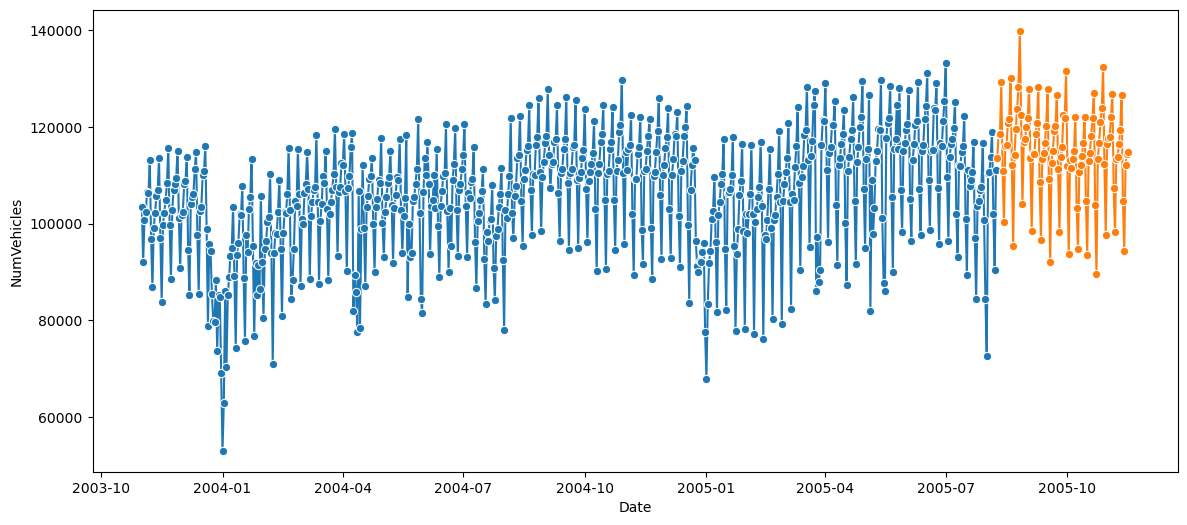

In [87]:
fig, ax1 = plt.subplots(figsize=(14,6))
_=sns.lineplot(x=df_train.index, y=df_train.NumVehicles,ax=ax1,  marker="o")
_=sns.lineplot(x=df_test.index, y=df_test.NumVehicles,ax=ax1,  marker="o")

### One way is to smooth out the data so you can see the overall trend.  Then visually determine the best way to model it
Below, I'm using a rolling average method to see what the average value is of a moving 7,28 and 256 day period<br>
<mark> why did I pick these numbers? A: Because we already showed that the data has a 7 day cycle (Mon-Sun). The moving average must be at least as long as this cycle, and preferably several times longer to smooth the approximation

In [88]:
moving_average7 = df_train.rolling(
    window=7,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=4,  # choose about half the window size
).mean()   

moving_average28 = df_train.rolling(
    window=28,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=14,  # choose about half the window size
).mean() 

moving_average256 = df_train.rolling(
    window=256,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=128,  # choose about half the window size
).mean() 
 

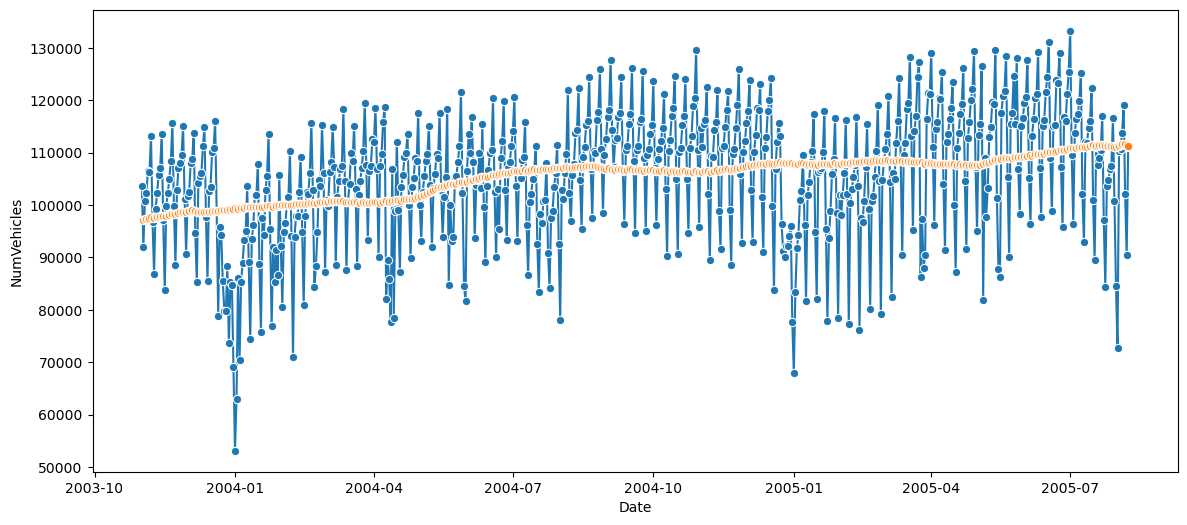

In [89]:
#lets plot them over original data
fig, ax1 = plt.subplots(figsize=(14,6))
_=sns.lineplot(x=df_train.index, y=df_train.NumVehicles,ax=ax1,  marker="o")
_=sns.lineplot(x=moving_average7.index, y=moving_average256.NumVehicles,ax=ax1,  marker="o")

### The moving average is showing that the overall trend is linear, so approximate it with linear regression

If it is not linear I would consider polynomial regression.  Something to capture the overall shape of the moving average line

### But there is still seasonality, specifically a 7 day repeating pattern
You can see this in the first 100 rows

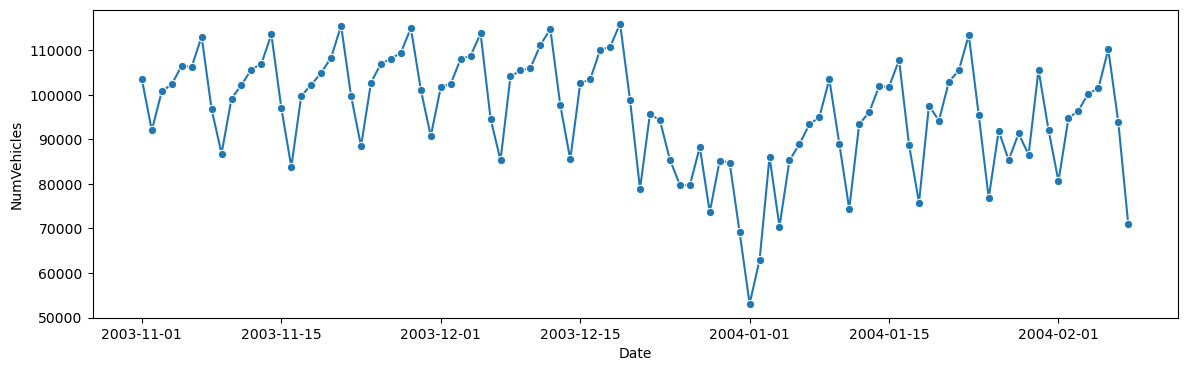

In [90]:
#get the first 100 rows
df_train100=df_train.iloc[:100,:]

#and lets see them
fig, ax1 = plt.subplots(figsize=(14,4))
_=sns.lineplot(x=df_train100.index, y='NumVehicles', data=df_train100,ax=ax1,  marker="o")

## Instead of trying to remove this seasonality, lets see if a gradient boosted tree (catboost) can do well on the detrended data
<mark> But it needs more information to go on than a single column,  all we can use are lags, whats a good number?<br>
since we have a repeating cycle of 7 days, lets add 7 lags to see if it helps the tree

<b>Train linear regressor and catboost On Train set
1. detrend (save regressor for use on test set)
2. add lags 
3. drop rows with NaNs 
4. train catboost regressor (save regressor for use on test set)
    
<b>Apply above transforms On Test set to get estimates
    
5. detrend (use regressor from 1)
6. add lags (same number as 2)
7. get preds from catboost (use regessor from 4 above)
8. add back trend
    
    
<b>get rsquared on test set predictions verses original ones

### Train linear regressor and catboost On Train set

In [91]:
#1.detrend (save regressor for use on test set)
mod1=ut.train_linreg_model(df_train.Time.values.reshape(-1,1),df_train.NumVehicles)
df_train.NumVehicles=df_train.NumVehicles-mod1.predict(df_train.Time.values.reshape(-1,1))

#2.add lags 
for i in range(1,8):
    df_train['Lag_'+str(i)]=df_train['NumVehicles'].shift(i)
    
#3.drop rows with NaNs    
df_train.dropna(inplace=True)  #alas goodbye to first 7 rows

#4.train catboost regressor 

#first seperate target
df_train_y=df_train['NumVehicles']
df_train.drop(columns=['NumVehicles'],inplace=True)

from catboost import CatBoostRegressor
clf = CatBoostRegressor(silent=True, random_state=42)
_=clf.fit(df_train, df_train_y)

### Apply above transforms On Test set to get estimates

In [92]:
#5.detrend (save regressor for use on test set)
df_test.NumVehicles=df_test.NumVehicles-mod1.predict(df_test.Time.values.reshape(-1,1))

#6.add lags 
for i in range(1,8):
    df_test['Lag_'+str(i)]=df_test['NumVehicles'].shift(i)

#6a.drop rows with NaNs(can fix this by reaching back into the train set, this is not data leakage!) 
df_test.dropna(inplace=True)  #alas goodbye to first 7 rows

# #remove the dependant var
df_test.drop(columns=['NumVehicles'],inplace=True)

# 7. get preds from catboost (use regessor from 4 above)
predcbs=clf.predict(df_test)

# 8. add back the trend
predslr=mod1.predict(df_test.Time.values.reshape(-1,1))

pred_tot=predcbs+ predslr

### Want to 'see' model predictions verses actuals are on test set before we run rsquared?
Run 

In [93]:
#remember we dropped the first few rows when calculating the lags
df_test_y_orig=df_test_y_orig[-len(predcbs):]

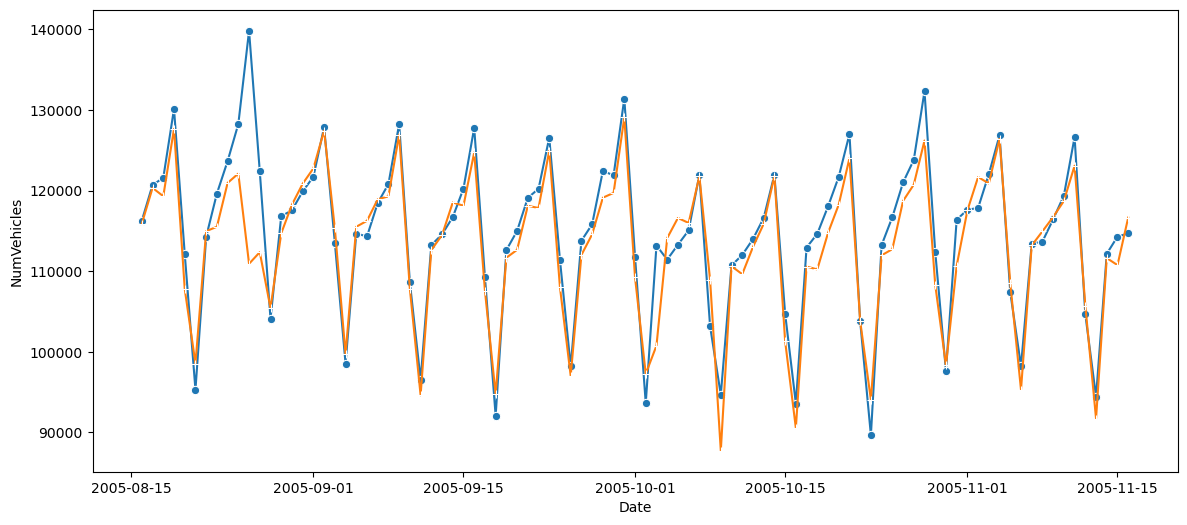

In [94]:
#lets plot them over original data
fig, ax1 = plt.subplots(figsize=(14,6))
_=sns.lineplot(x=df_test.index, y=df_test_y_orig,ax=ax1,  marker="o")

#run the following with predcbs  then add in the predslr
_=sns.lineplot(x=df_test.index, y=predcbs+predslr,ax=ax1,  marker="+")

### Get rsquared on test set predictions verses original ones

In [95]:
from utils import rsquared
preds=clf.predict(df_test)
score=rsquared(pred_tot,df_test_y_orig)
score

0.8130680992851096

# <mark> Permutation Importance 

In [96]:
from sklearn.inspection import permutation_importance

In [98]:
%%time
feature_names=df_test.columns
result = permutation_importance(
    clf, df_test, df_test_y_orig, n_repeats=10, random_state=42, n_jobs=2, scoring=None)
forest_importances = pd.Series(result.importances_mean, index=feature_names)

CPU times: user 5.59 ms, sys: 50 ms, total: 55.5 ms
Wall time: 1.02 s


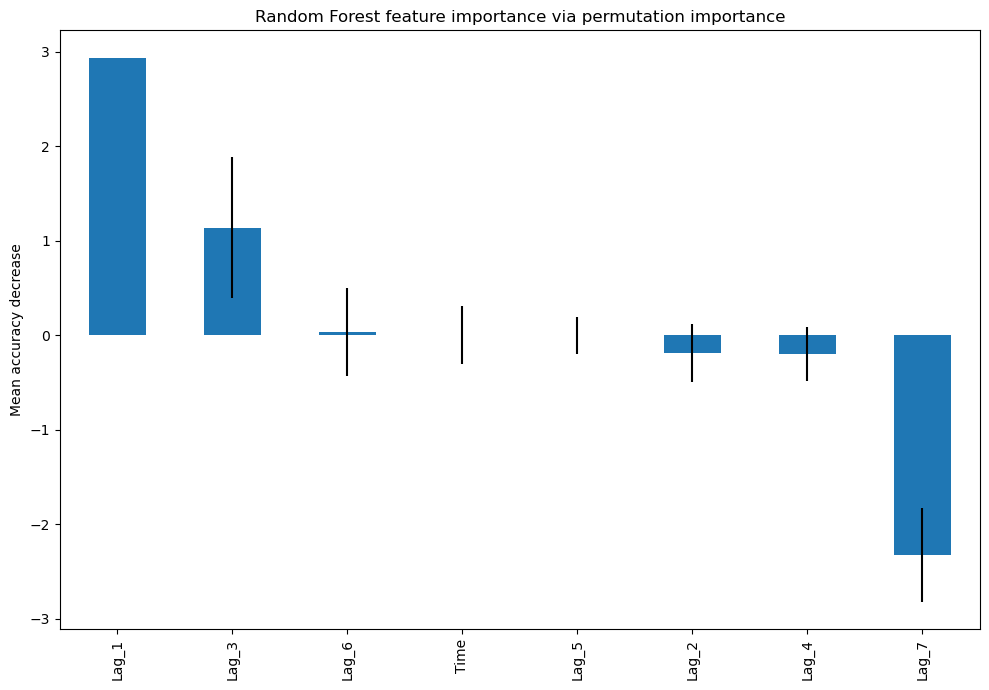

In [99]:
#plot em
forest_importances = forest_importances.sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10,7))
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Random Forest feature importance via permutation importance")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()